# Generative Adversarial Networks (GAN)

In this notebook, we will go through basics of GAN and implement wgan and dcgan on different dataset other than MNIST. We will use pokemon dataset.

**Issue** : *Model keeps breaking ... for both wgan and dcgan ... Mode collapse* Any suggestions?

Increase size of network? Reduce resolution of images?

Here we will use [keras](https://keras.io/  "Keras Homepage").


Everything is explained in-detail in [blog post](https://dudeperf3ct.github.io/gan/2019/04/13/Power-of-GAN/). This is notebook which replicates the result of blog and runs in colab. Enjoy!


#### Run in Colab

You can run this notebook in google colab.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dudeperf3ct/DL_notebooks/blob/master/GAN/gan_keras.ipynb)



### Get Data

In [0]:
import os
from pathlib import Path
os.mkdir('data')
os.mkdir('images')

path = Path('data')

In [0]:
from google.colab import files
files.upload()

In [0]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

In [0]:
!kaggle datasets download -d dollarakshay/pokemon-images -p {path}

In [0]:
!unzip {path}/'pokemon-images.zip' -d {path}

In [0]:
!unzip {path}/'POKEMON.zip' -d {path}

In [7]:
!ls -lR /content/data/POKEMON/*.png | wc -l #number of train images

801


## EDA

In [0]:
from pathlib import Path
path = Path('data/POKEMON')

In [0]:
import matplotlib.pyplot as plt
import random
import imageio
%matplotlib inline

def show_images(img_path, path, rows=2, columns=4):
    fig=plt.figure(figsize=(18, 9))
    for i in range(1, columns*rows+1):
        img = imageio.imread(path/img_path[i-1])    
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        plt.title(f'Image size: {img.shape}')
        plt.axis('off')

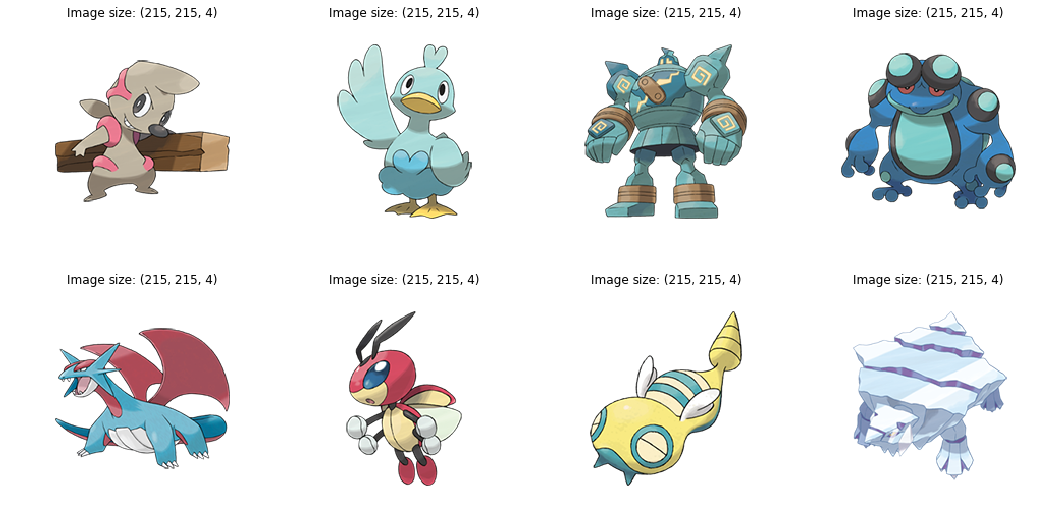

In [10]:
# no, I don't know their names :(
rnd_images = random.sample(os.listdir(f'{path}'), 8)
show_images(rnd_images, path)

# Keras

Code Credits: [eriklindernoren](https://github.com/eriklindernoren/Keras-GAN/) 

This repo contains almost all implementations for MNIST dataset mostly.

In [1]:
import numpy as np
import os
import keras
import time
import keras.backend as K
from keras.datasets import mnist
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop, SGD
import imageio
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from pathlib import Path
path = Path('data/POKEMON')

Using TensorFlow backend.


## Vanilla GAN

In [0]:
class GAN():
    
    def __init__(self):
        
        self.latent_dim = 100
        self.img_shape = (28, 28, 1)
        optimizer = Adam(0.0002, 0.5)
        
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, 
                                   metrics=['accuracy'])
        
        self.generator = self.build_generator()
        
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        self.discriminator.trainable = False
        real_fake = self.discriminator(img)

        self.combined = Model(z, real_fake)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    

    # generator takes a noise z and produces a fake image
    def build_generator(self):
        
        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        
        return Model(noise, img)

        
    # discriminator takes half real and half generated images as input
    # and determines whether the input image is real or fake
    def build_discriminator(self):
        
        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        real_fake = model(img)
        
        return Model(img, real_fake)
        
    # train generator and discriminator
    def train(self, epochs, batch_size=128, show_image_interval=50, print_every=50):

        # Load the dataset
        (train_x, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        train_x = train_x / 127.5 - 1.
        train_x = np.expand_dims(train_x, axis=3)

        # Adversarial ground truths
        real = np.ones((batch_size, 1))   # real labels = 1
        fake = np.zeros((batch_size, 1))  # fake labels = 0

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, train_x.shape[0], batch_size)
            imgs = train_x[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, real)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as real)
            g_loss = self.combined.train_on_batch(noise, real)

            # If at save interval => save generated image samples
            if epoch % print_every == 0:
                
                # Plot the progress
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))          
            
            # If at save interval => save generated image samples
            if epoch % show_image_interval == 0:
                
                # Plot the progress
                self.sample_images(epoch)
        
        
    # show images after every epoch    
    def sample_images(self, epoch):
            r, c = 5, 5
            noise = np.random.normal(0, 1, (r * c, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Rescale images 0 - 1
            gen_imgs = 0.5 * gen_imgs + 0.5

            fig, axs = plt.subplots(r, c)
            cnt = 0
            for i in range(r):
                for j in range(c):
                    axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                    axs[i,j].axis('off')
                    cnt += 1
            fig.savefig("images/%d.png" % epoch)
            plt.show()
            plt.close()

In [0]:
gan = GAN()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.765853, acc.: 31.25%] [G loss: 0.623925]


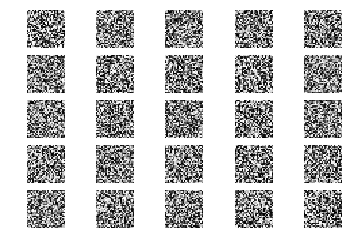

1000 [D loss: 0.593612, acc.: 76.56%] [G loss: 0.879008]
2000 [D loss: 0.586332, acc.: 70.31%] [G loss: 0.976600]


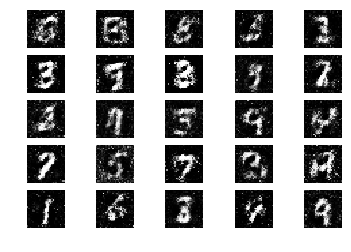

3000 [D loss: 0.627279, acc.: 66.41%] [G loss: 0.921672]
4000 [D loss: 0.622819, acc.: 65.62%] [G loss: 0.983688]


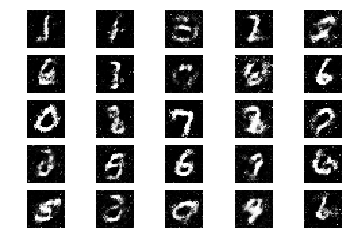

5000 [D loss: 0.645997, acc.: 60.94%] [G loss: 0.888784]
6000 [D loss: 0.637311, acc.: 67.97%] [G loss: 0.910214]


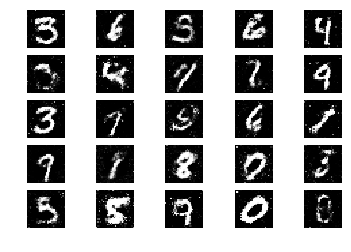

7000 [D loss: 0.673910, acc.: 57.03%] [G loss: 0.872812]
8000 [D loss: 0.673418, acc.: 56.25%] [G loss: 0.842252]


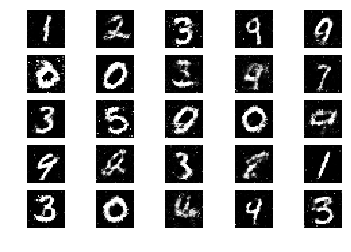

9000 [D loss: 0.611018, acc.: 69.53%] [G loss: 0.924994]
10000 [D loss: 0.672338, acc.: 56.25%] [G loss: 0.894815]


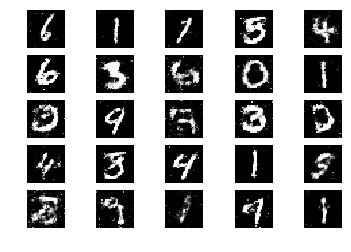

11000 [D loss: 0.667524, acc.: 57.81%] [G loss: 0.876222]
12000 [D loss: 0.663160, acc.: 60.16%] [G loss: 0.900611]


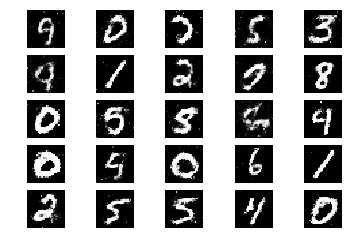

13000 [D loss: 0.644675, acc.: 66.41%] [G loss: 0.926055]
14000 [D loss: 0.660563, acc.: 60.94%] [G loss: 0.885348]


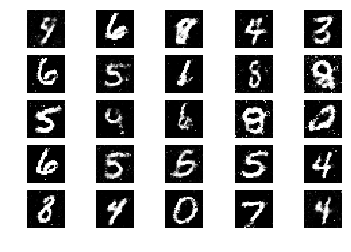

15000 [D loss: 0.676407, acc.: 52.34%] [G loss: 0.881061]
16000 [D loss: 0.672735, acc.: 63.28%] [G loss: 0.881452]


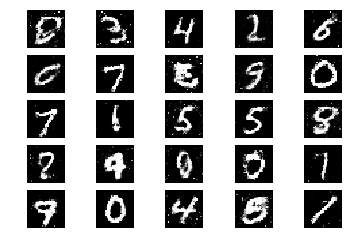

17000 [D loss: 0.659088, acc.: 57.03%] [G loss: 0.909777]
18000 [D loss: 0.654648, acc.: 57.81%] [G loss: 0.874123]


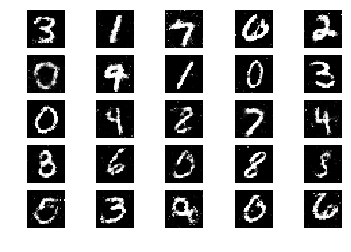

19000 [D loss: 0.715041, acc.: 53.12%] [G loss: 0.854828]
20000 [D loss: 0.653853, acc.: 58.59%] [G loss: 0.919075]


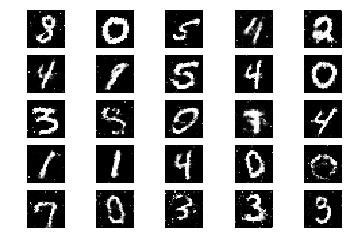

21000 [D loss: 0.622902, acc.: 65.62%] [G loss: 0.984195]
22000 [D loss: 0.654252, acc.: 62.50%] [G loss: 0.913303]


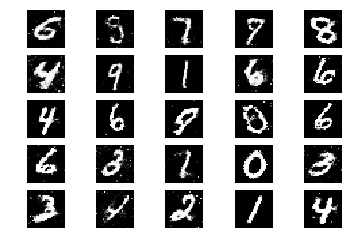

23000 [D loss: 0.620811, acc.: 67.97%] [G loss: 0.988130]
24000 [D loss: 0.641883, acc.: 60.94%] [G loss: 0.970117]


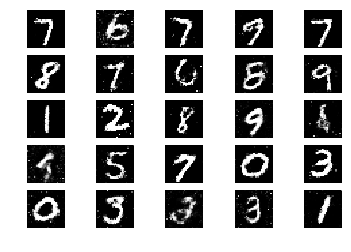

25000 [D loss: 0.605170, acc.: 74.22%] [G loss: 0.894414]
26000 [D loss: 0.624276, acc.: 71.09%] [G loss: 0.930403]


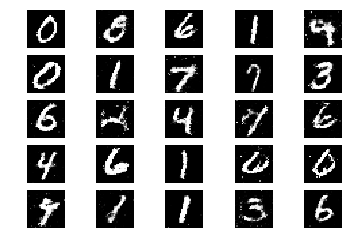

27000 [D loss: 0.668614, acc.: 57.03%] [G loss: 1.027314]
28000 [D loss: 0.713799, acc.: 54.69%] [G loss: 0.914444]


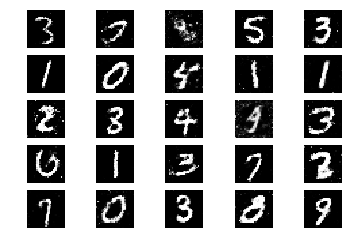

29000 [D loss: 0.647750, acc.: 65.62%] [G loss: 0.913008]


In [0]:
gan.train(epochs=30000, batch_size=64, show_image_interval=2000, print_every=1000)

## WGAN

In [0]:
class WGAN():
    
    
    def __init__(self):
        
        self.latent_dim = 100
        self.img_shape = (224, 224, 1)
        self.channels = 1

        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        self.clip_value = 0.01
        optimizer = RMSprop(lr=0.00005)
        
        self.critic = self.build_critic()
        self.critic.compile(loss=self.wasserstein_loss, optimizer=optimizer,
                            metrics=['accuracy'])
        
        self.generator = self.build_generator()
        
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        for layer in self.critic.layers:
            layer.trainable = False
        output = self.critic(img)

        self.combined = Model(z, output)
        self.combined.compile(loss=self.wasserstein_loss, optimizer=optimizer,
                              metrics=['accuracy'])
 
    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def load_data(self):
    
        arr = []
        for fn in tqdm(os.listdir(path)):
            img = Image.open(path/fn)
            img = img.resize((224, 224), Image.ANTIALIAS).convert(mode='L')
            img = np.asarray(img)
            arr.append(img)

        return np.array(arr)    
    
    # generator takes a noise z and produces a fake image
    def build_generator(self):
        
        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D(size=(4, 4)))
        model.add(Conv2D(64, kernel_size=5, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D(size=(4, 4)))
        model.add(Conv2D(self.channels, kernel_size=5, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        
        return Model(noise, img)

        
    # critic takes half real and half generated images as input
    # and determines whether the input image is real or fake
    def build_critic(self):
        
        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.75))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.75))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.75))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.75))
        model.add(Flatten())
        model.add(Dense(1))
        
        model.summary()

        img = Input(shape=self.img_shape)
        out = model(img)
        
        return Model(img, out)

    # train generator and discriminator
    def train(self, train_x, std, mean, epochs, batch_size=128, show_image_interval=50, print_every=50):

        # Rescale -1 to 1
        train_x = (train_x - mean) / std
        train_x = np.expand_dims(train_x, axis=3)

        # Adversarial ground truths
        real = -np.ones((batch_size, 1))   # real labels
        fake = np.ones((batch_size, 1))  # fake labels

        for epoch in range(epochs):
            start = time.time()
            for nc in range(self.n_critic):
                
                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, train_x.shape[0], batch_size)
                imgs = train_x[idx]

                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Generate a batch of new images
                gen_imgs = self.generator.predict(noise)

                # Train the discriminator
                d_loss_real = self.critic.train_on_batch(imgs, real)
                d_loss_fake = self.critic.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # Clip critic weights
                for l in self.critic.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    l.set_weights(weights)                
                
                
            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (to have the discriminator label samples as real)
            g_loss = self.combined.train_on_batch(noise, real)

            # If at save interval => save generated image samples
            if epoch % print_every == 0:
                
                # Plot the progress
                print ("%d [D loss: %f] [G loss: %f] [Time : %.2f]" % (epoch, 1-d_loss[0], 1-g_loss[0], time.time()-start))          
            
            # If at save interval => save generated image samples
            if epoch % show_image_interval == 0:
                
                # Plot the progress
                self.sample_images(epoch, std, mean)
        
        
    # show images after every epoch    
    def sample_images(self, epoch, std, mean):
            r, c = 5, 5
            noise = np.random.normal(0, 1, (r * c, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Rescale images 0 - 1
            gen_imgs = std * gen_imgs + mean

            fig, axs = plt.subplots(r, c)
            cnt = 0
            for i in range(r):
                for j in range(c):
                    axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                    axs[i,j].axis('off')
                    cnt += 1
            fig.savefig("images/%d.png" % epoch)
            plt.show()
            plt.close()

In [3]:
wgan = WGAN()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 112, 112, 16)      160       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        4640      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 57, 57, 32)        0         
_________________________________________________________________
batch_normalization_1

In [4]:
train_x = wgan.load_data()
print ('\nShape:', train_x.shape)
mean = train_x.mean(axis=(0,1,2))/255
std = train_x.std(axis=(0,1,2))/255
print ('Mean :', mean, 'Std: ', std)

100%|██████████| 801/801 [00:03<00:00, 216.41it/s]



Shape: (801, 224, 224)
Mean : 0.15032183041365735 Std:  0.2803452670512909


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.999899] [G loss: 1.000257] [Time : 9.59]


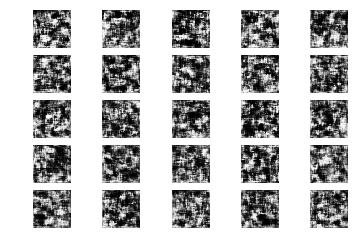

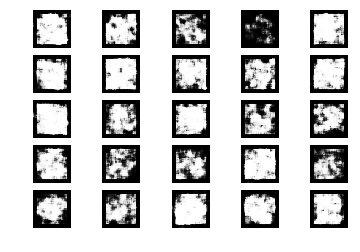

100 [D loss: 3.166272] [G loss: -0.202796] [Time : 1.99]


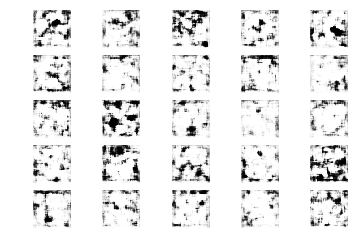

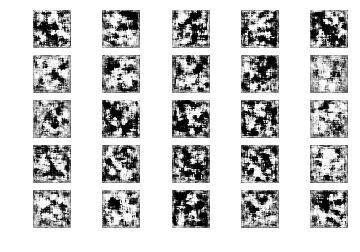

200 [D loss: 3.280561] [G loss: 0.011326] [Time : 2.00]


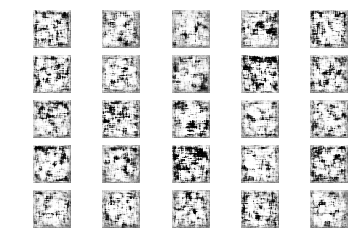

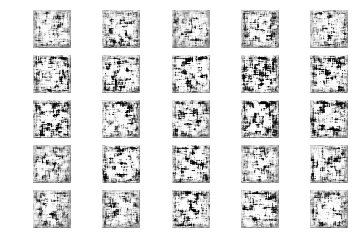

300 [D loss: 3.390830] [G loss: 0.103785] [Time : 1.99]


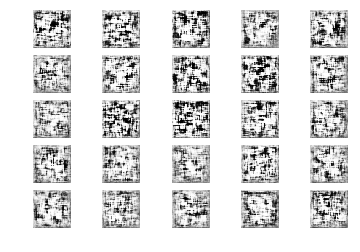

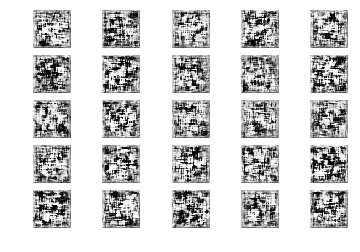

400 [D loss: 3.319943] [G loss: 0.148906] [Time : 1.99]


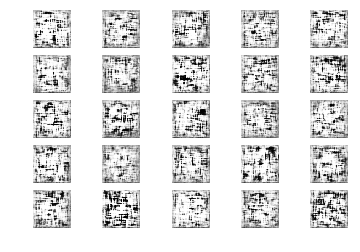

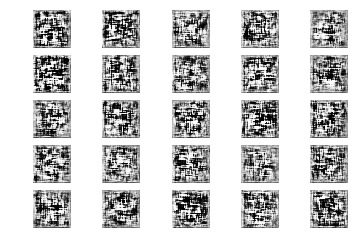

500 [D loss: 3.394278] [G loss: 0.155443] [Time : 1.99]


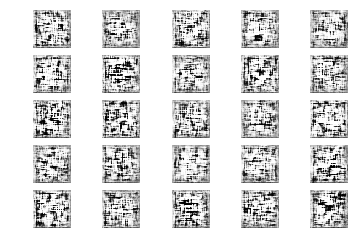

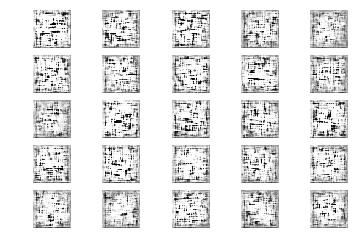

600 [D loss: 3.361614] [G loss: 0.157856] [Time : 1.99]


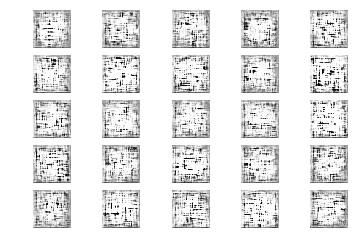

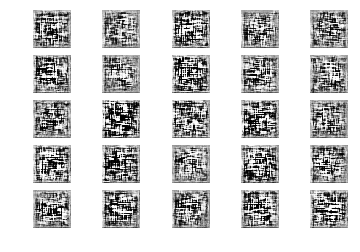

700 [D loss: 3.433783] [G loss: 0.162105] [Time : 1.99]


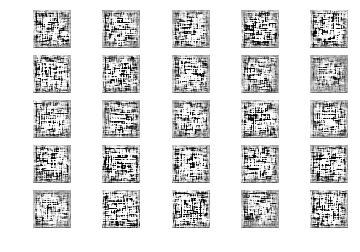

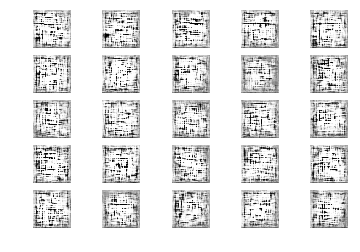

800 [D loss: 3.391743] [G loss: 0.129675] [Time : 2.00]


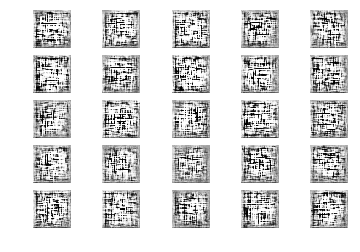

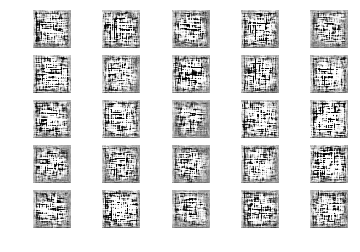

900 [D loss: 3.384538] [G loss: 0.174369] [Time : 2.00]


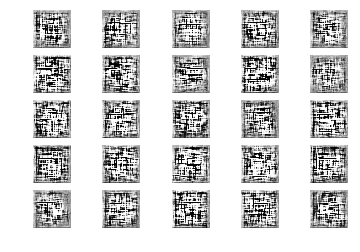

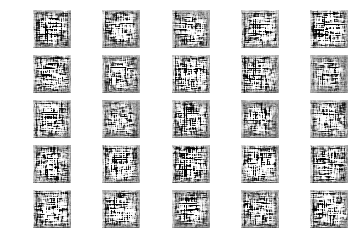

1000 [D loss: 3.373078] [G loss: 0.174912] [Time : 2.00]


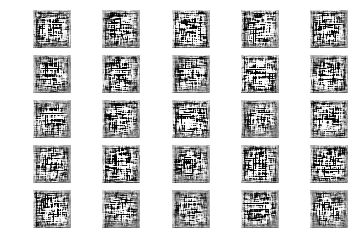

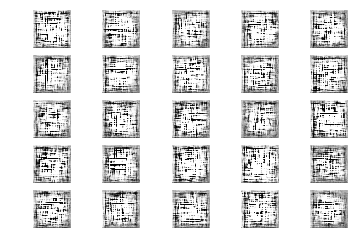

1100 [D loss: 3.393084] [G loss: 0.157511] [Time : 1.99]


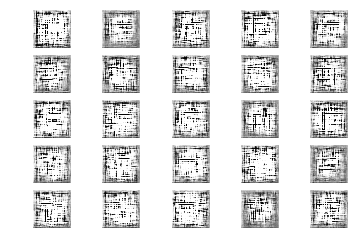

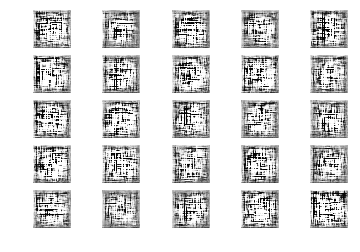

1200 [D loss: 3.308585] [G loss: 0.140502] [Time : 1.99]


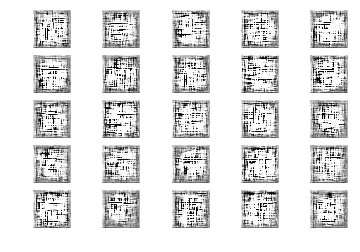

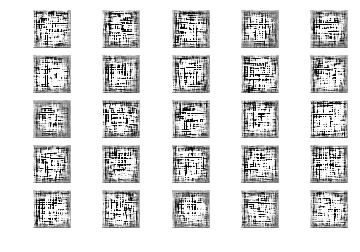

1300 [D loss: 3.280487] [G loss: 0.178681] [Time : 1.99]


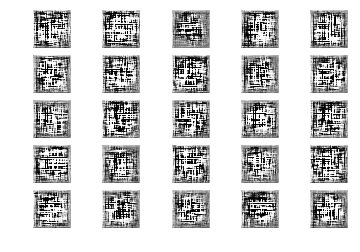

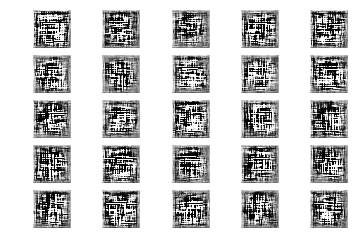

1400 [D loss: 3.294856] [G loss: 0.133161] [Time : 2.00]


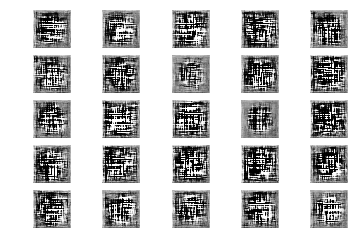

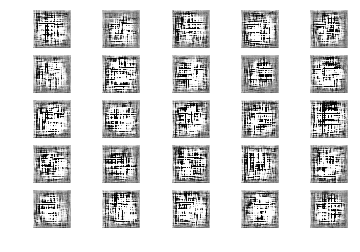

1500 [D loss: 3.396055] [G loss: 0.147288] [Time : 1.99]


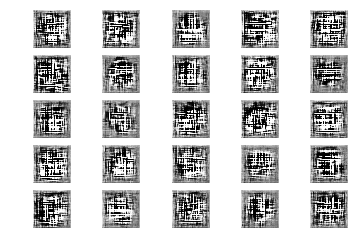

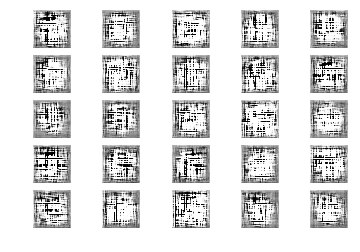

1600 [D loss: 3.328349] [G loss: 0.178852] [Time : 1.99]


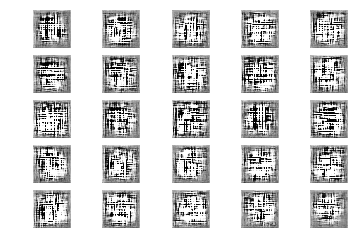

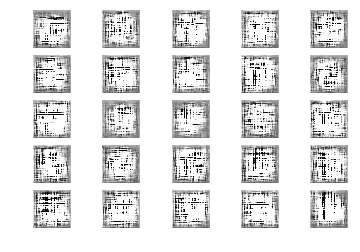

1700 [D loss: 3.448121] [G loss: 0.144100] [Time : 1.99]


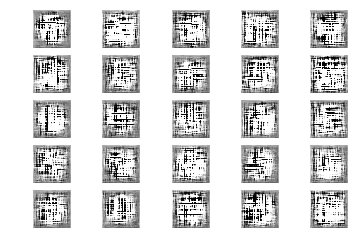

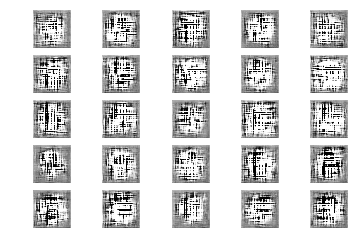

1800 [D loss: 3.420735] [G loss: 0.167567] [Time : 1.99]


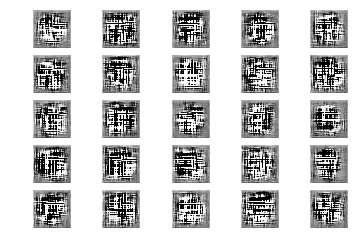

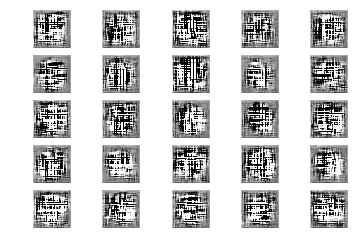

1900 [D loss: 3.342159] [G loss: 0.150319] [Time : 1.99]


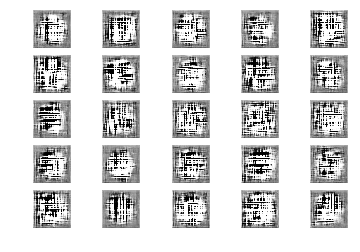

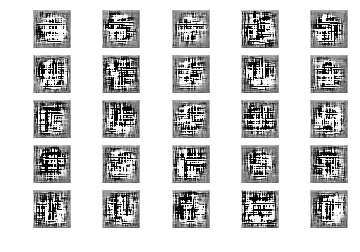

2000 [D loss: 3.442619] [G loss: 0.119697] [Time : 1.99]


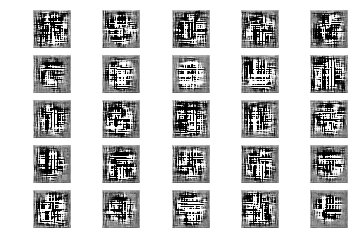

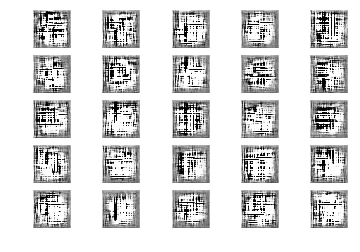

2100 [D loss: 3.275270] [G loss: 0.152092] [Time : 2.00]


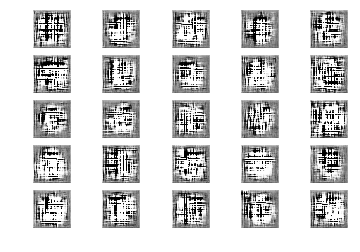

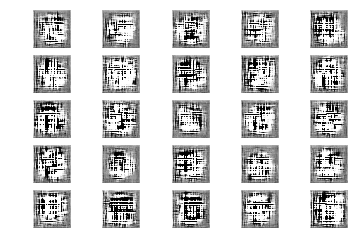

2200 [D loss: 3.340546] [G loss: 0.164755] [Time : 2.00]


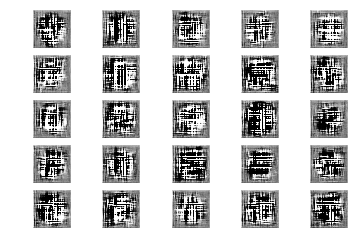

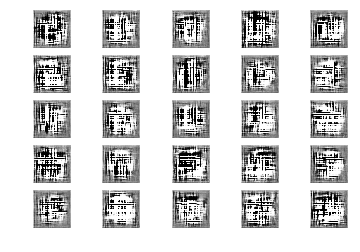

2300 [D loss: 3.342344] [G loss: 0.176087] [Time : 1.99]


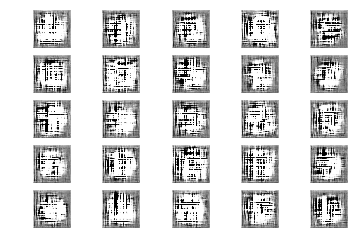

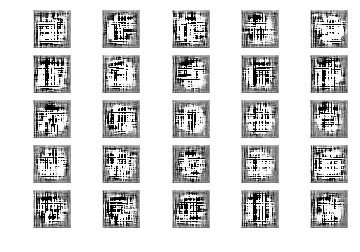

2400 [D loss: 3.337328] [G loss: 0.157680] [Time : 1.99]


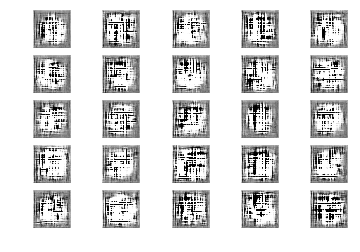

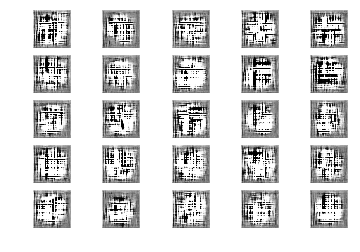

2500 [D loss: 3.315300] [G loss: 0.166681] [Time : 1.99]


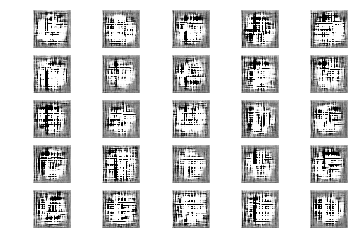

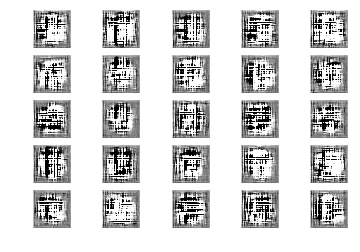

2600 [D loss: 3.404458] [G loss: 0.172144] [Time : 1.99]


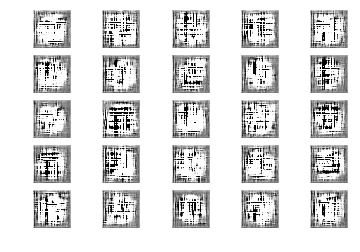

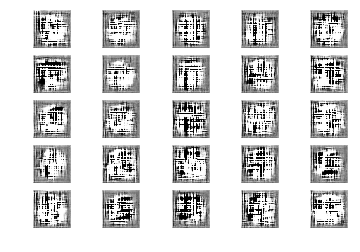

2700 [D loss: 3.354479] [G loss: 0.150327] [Time : 2.00]


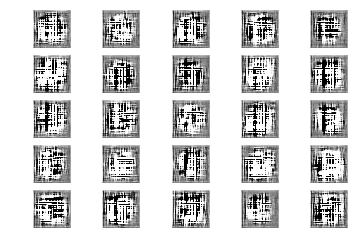

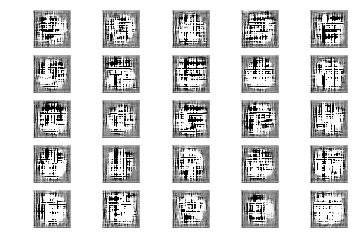

2800 [D loss: 3.357838] [G loss: 0.135317] [Time : 2.00]


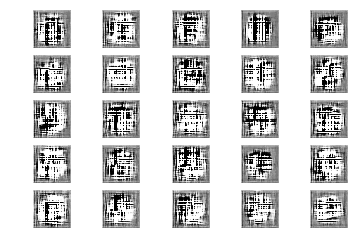

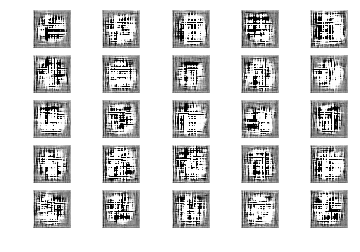

2900 [D loss: 3.349236] [G loss: 0.141387] [Time : 1.99]


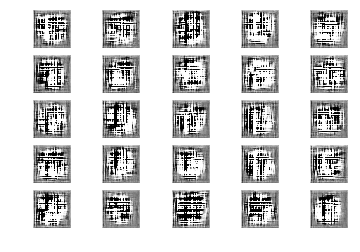

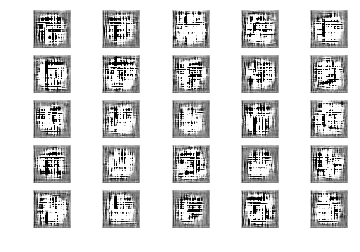

In [5]:
wgan.train(train_x, std, mean, epochs=3000, batch_size=64, show_image_interval=50, print_every=100)

## DCGAN

In [0]:
class DCGAN():
    
    def __init__(self):
        
        self.latent_dim = 100
        self.img_shape = (224, 224, 1)
        self.channels = 1
        optimizer = SGD(lr=1e-4, momentum=0.9, nesterov=True)
        
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, 
                                   metrics=['accuracy'])
        
        self.generator = self.build_generator()
        
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        for layer in self.discriminator.layers:
            layer.trainable = False
        real_fake = self.discriminator(img)

        self.combined = Model(z, real_fake)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        self.discriminator.trainable = True
    

    def load_data(self):
    
        arr = []
        for fn in tqdm(os.listdir(path)):
            img = Image.open(path/fn)
            img = img.resize((224, 224), Image.ANTIALIAS).convert(mode='L')
            img = np.asarray(img)
            arr.append(img)

        return np.array(arr)    
    
    # generator takes a noise z and produces a fake image
    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D(size=(4, 4)))
        model.add(Conv2D(64, kernel_size=5, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D(size=(4, 4)))
        model.add(Conv2D(self.channels, kernel_size=5, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        
        return Model(noise, img)

        
    # critic takes half real and half generated images as input
    # and determines whether the input image is real or fake
    def build_discriminator(self):
        
        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.75))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.75))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.75))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.75))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()
        
        img = Input(shape=self.img_shape)
        out = model(img)
        
        return Model(img, out)
        
    # train generator and discriminator
    def train(self, train_x, std, mean, epochs, batch_size, show_image_interval, print_every):

        # Rescale -1 to 1
        train_x = (train_x - mean) / std
        train_x = np.expand_dims(train_x, axis=3)

        # Adversarial ground truths
        real = np.ones((batch_size, 1))   # real labels = 1
        fake = np.zeros((batch_size, 1))  # fake labels = 0

        for epoch in range(epochs):
            
            start = time.time()
            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, train_x.shape[0], batch_size)
            imgs = train_x[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, real)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as real)
            g_loss = self.combined.train_on_batch(noise, real)

            # If at save interval => save generated image samples
            if epoch % print_every == 0:
                
                # Plot the progress
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))          
            
            # If at save interval => save generated image samples
            if epoch % show_image_interval == 0:
                
                # Plot the progress
                self.sample_images(epoch, std, mean)
        
        
    # show images after every epoch    
    def sample_images(self, epoch, std, mean):
            r, c = 5, 3
            noise = np.random.normal(0, 1, (r * c, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Rescale images 0 - 1
            gen_imgs = std * gen_imgs + mean

            fig, axs = plt.subplots(r, c)
            cnt = 0
            for i in range(r):
                for j in range(c):
                    
                    axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                    axs[i,j].axis('off')
                    cnt += 1
            fig.savefig("images/%d.png" % epoch)
            plt.show()
            plt.close()

In [7]:
dcgan = DCGAN()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 112, 112, 32)      320       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 112, 112, 32)      0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 57, 57, 64)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 57, 57, 64)        256       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 57, 57, 64)        0         
__________

In [8]:
train_x = dcgan.load_data()
print ('\nShape:', train_x.shape)
mean = train_x.mean(axis=(0,1,2))/255
std = train_x.std(axis=(0,1,2))/255
print ('Mean :', mean, 'Std: ', std)

100%|██████████| 801/801 [00:03<00:00, 233.39it/s]



Shape: (801, 224, 224)
Mean : 0.15032183041365735 Std:  0.2803452670512909


Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.297705, acc.: 42.19%] [G loss: 1.099573]


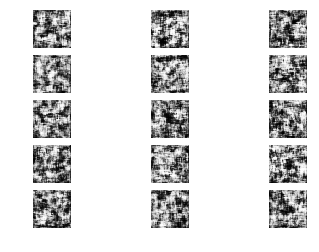

100 [D loss: 0.061214, acc.: 98.44%] [G loss: 4.812683]
200 [D loss: 0.497477, acc.: 78.91%] [G loss: 3.285566]


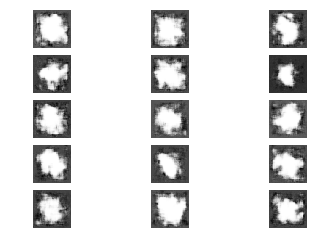

300 [D loss: 0.043651, acc.: 99.22%] [G loss: 7.719854]
400 [D loss: 0.015362, acc.: 99.22%] [G loss: 9.295956]


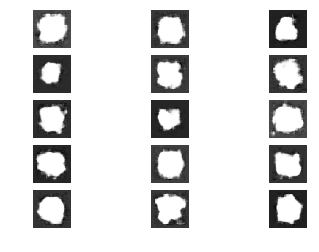

500 [D loss: 0.001490, acc.: 100.00%] [G loss: 9.136290]
600 [D loss: 0.000214, acc.: 100.00%] [G loss: 9.206803]


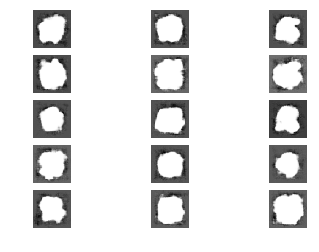

700 [D loss: 0.005184, acc.: 100.00%] [G loss: 7.365206]
800 [D loss: 0.001736, acc.: 100.00%] [G loss: 8.123962]


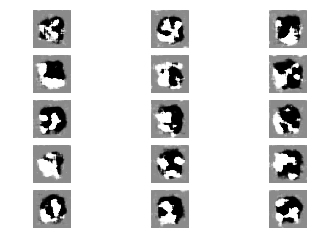

900 [D loss: 0.012769, acc.: 99.22%] [G loss: 8.318855]
1000 [D loss: 0.016676, acc.: 99.22%] [G loss: 8.640358]


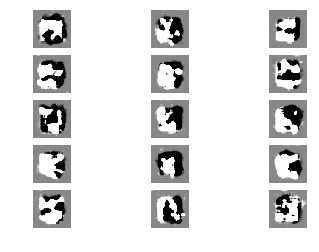

1100 [D loss: 0.002159, acc.: 100.00%] [G loss: 8.404669]
1200 [D loss: 0.000684, acc.: 100.00%] [G loss: 9.056108]


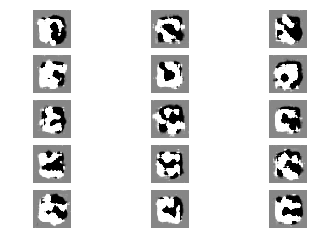

1300 [D loss: 0.003922, acc.: 100.00%] [G loss: 8.999838]
1400 [D loss: 0.000360, acc.: 100.00%] [G loss: 9.033692]


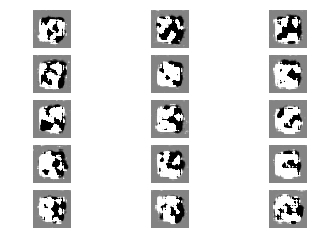

1500 [D loss: 0.000673, acc.: 100.00%] [G loss: 9.551341]
1600 [D loss: 0.000474, acc.: 100.00%] [G loss: 8.504171]


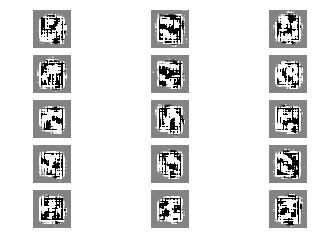

1700 [D loss: 0.001227, acc.: 100.00%] [G loss: 8.654150]
1800 [D loss: 0.001356, acc.: 100.00%] [G loss: 8.445135]


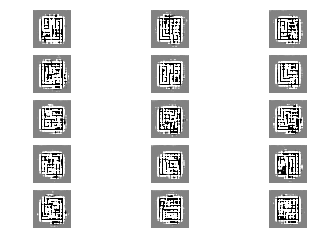

1900 [D loss: 0.001372, acc.: 100.00%] [G loss: 8.750092]
2000 [D loss: 0.002149, acc.: 100.00%] [G loss: 8.492198]


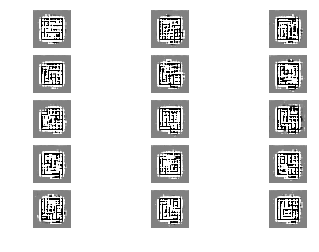

2100 [D loss: 0.003096, acc.: 100.00%] [G loss: 8.509323]
2200 [D loss: 0.011400, acc.: 99.22%] [G loss: 8.182114]


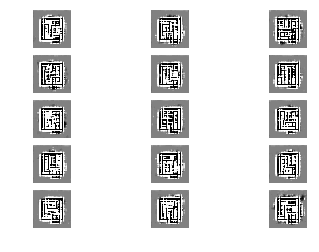

2300 [D loss: 0.002091, acc.: 100.00%] [G loss: 7.839404]
2400 [D loss: 0.008322, acc.: 99.22%] [G loss: 8.160862]


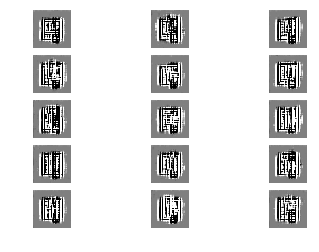

2500 [D loss: 0.003170, acc.: 100.00%] [G loss: 8.147887]
2600 [D loss: 0.001654, acc.: 100.00%] [G loss: 8.325842]


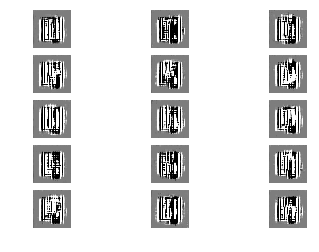

2700 [D loss: 0.003523, acc.: 100.00%] [G loss: 8.661148]
2800 [D loss: 0.001435, acc.: 100.00%] [G loss: 8.251276]


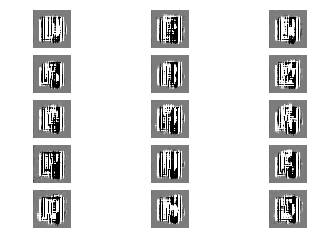

2900 [D loss: 0.000940, acc.: 100.00%] [G loss: 8.668591]


In [9]:
dcgan.train(train_x, std, mean, epochs=3000, batch_size=64, show_image_interval=200, print_every=100)